# Mapping dark matter in galaxy clusters

Galaxy clusters are the largest cosmic structures in the sky. 

* They contain millions of galaxies, and each galaxy contains billions of stars; 
* They are big reservoirs of dark matter. Dark matter accounts for 90% of the total mass; 
* Being incredibly massive, they are very strong gravitational lenses. Gravitational lensing is the effect of matter curving space time. 
* When the light from  distant galaxies passes near a massive galaxy cluster, it is deflected and the source appears distorted, like when we observe something through a piece of glass. 

<img src='./Gravitational-lensing-galaxyApril12_2010-1024x768.jpg' style='width: 50%'/>

** By measuring the distortions of the images of the distant galaxies, we can invert the process of lensing and determine how the matter responsible for this effect is distributed. As said, the vast majority of this matter is dark.** 

<img src='./f7385a_43031cf41afe4858a462cdb2b2b0fdc1.png' style='width: 50%'/>

# A major obstacle: finding the lensed galaxies

When we look at the sky around a galaxy cluster we see galaxies belonging to two classes:

* **Lensed galaxies**: galaxies in the cluster background are galaxies lensed by the foreground mass distribution of the cluster. ** These are the galaxies we need for our analysis!**
* **Unlensed galaxies**: galaxies within the cluster or in its foreground are not lensed by the cluster. **These galaxies are very dangerous for us, we need to get rid of them, otherwise our dark matter measurements will be biased-low!**

# A classification problem

## Features

In the field-of-view of the telescope, we have millions of unlensed and lensed galaxies. Our job is to separate these two classes of sources. This is a classification problem which can be solved using a machine learning approach.

What are the features we might use? 
* **galaxy "colors"**: galaxies residing in clusters are typically **red** in color. This is because, they contain primarily old stars, which are red. Conversely, galaxies outside the clusters are **blue**, because they contain young stars. In particular, the galaxies far away from us are young galaxies: remember that their light takes billions of years to reach us. Thus, we see them as they were in a younger universe. Unfortunately, because of the expansion of the universe, galaxies are moving away from us at a speed which is roughly proportional to their distance. Due to the Doppler effect, they are reddened. Thus the classes of lensed and unlensed sources are partially overlapped.

* **galaxy luminosities**: the nearest, unlensed, galaxies will generally appear brighter than the most distant, lensed, ones.

* **galaxy distance from the center of the cluster**: of course galaxies in clusters are "clustered"!


## Training, testing, validation

Although we are typically working with millions of galaxies, in this demo I am using a small catalog containing ~2500 entries. Here is how the catalog looks like:



In [6]:
# import the relevant packages
import numpy as np
import pandas as pd
import seaborn as sns

# read the matched catalog into a pandas dataframe and rename some of the columns. 
# prepare the catalog for the following analysis
df=pd.read_csv('matched.cat')
df.dropna(axis=1,inplace=True)
df.columns.values[0:7]=['name','ra','dec','z',' z QF','Reference','Kron R']


For these galaxies, we have used spectroscopy to determine the distance from us. Thus each entry can be **labeled**. This is the **training set** for the supervised learning classification task. The galaxies are equally distributed among the two classes (lensed vs unlensed).

## Feature extraction and catalog cleaning

The catalog does not contain colors yet. Rather, it contains measurements of the brightness of each galaxy observed with a telescope with 5 different filters (B,V,R,I,Z). **Colors in astronomy are differences between brightnesses in different filters.** With these 5 brightnesses, we can generate 10 independent colors. These are the features to be used.   

Columns RA and DEC contain the coordinates of the galaxies in the sky. These coordinates can be used to define the **distance from the cluster center**, whose position is also known.

The column "Kron R" contains the brightness of the galaxy, which is the last feature we need. 

We can get rid of many of the columns in the catalog.

In [7]:
def createFeatures(df,columns):
    # create new columns in the dataframe containing different colors which can be generated
    # using the available bands
    import numpy as np

    colors=[]
    for i in xrange(columns.size-1): 
        for j in xrange(i+1,columns.size):
            df[columns[i]+''+columns[j]] = df[columns[i]]-df[columns[j]]
            colors.append(columns[i]+''+columns[j])
    
    return np.array(colors)

def addDistanceFromCenter(df,center):
    # compute distances  of all galaxies from the cluster center
    ra=df['ra'].values
    dec=df['dec'].values
    x=-(ra-center[0])*(np.cos(center[1]/180.0*np.pi)*3600.0)
    y=(dec-center[1])*3600.0
    r=np.sqrt(x**2+y**2)
    df['dist']=r

cols=np.array(['B','V','R','I','Z'])
center=np.array([181.55063,-8.8009665])
colors=createFeatures(df,cols)

addDistanceFromCenter(df,center)

# some columns can be dropped:
df.drop('RA',1,inplace=True)
df.drop('Dec',1,inplace=True)
df.drop('Reference',1,inplace=True)
df.drop('X',1,inplace=True)
df.drop('Y',1,inplace=True)
df.drop(df.columns[8:18],1,inplace=True)


We give a look at the data we have to work with.

In [3]:
df.describe()

,ra,dec,z,z QF,Kron R,id,area,Separation,BV,BR,BI,BZ,VR,VI,VZ,RI,RZ,IZ,dist
count,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000
mean,181.572053,-8.806062,0.496660,3.081426,22.250011,27580.377861,239.534334,0.034965,0.576999,1.142087,1.700248,1.794713,0.565089,1.123250,1.217714,0.558161,0.652626,0.094464,505.411312
std,0.121131,0.095611,0.340356,1.529653,1.195874,10849.661339,491.271864,0.041492,5.244630,4.717145,6.213617,4.753871,2.379163,4.694922,2.424105,4.042860,0.326553,4.034639,234.078185
min,181.271914,-9.002202,0.000000,2.000000,9.990000,6868.000000,9.000000,0.000540,-122.410700,-121.916200,-121.268500,-121.030300,-121.377900,-120.821700,-120.552200,-0.318100,-0.394800,-121.379500,0.181539
25%,181.483943,-8.882864,0.421400,2.000000,21.600000,19000.000000,88.000000,0.015402,0.457800,0.935000,1.194900,1.359400,0.410700,0.675400,0.851500,0.243100,0.403000,0.163200,333.439676
50%,181.572924,-8.806062,0.468700,3.000000,22.420000,27288.000000,145.000000,0.025048,0.650100,1.174100,1.549000,1.776900,0.612100,0.993600,1.199800,0.385500,0.612000,0.238800,512.723413
75%,181.668227,-8.736987,0.594700,3.000000,23.080000,34785.000000,249.000000,0.038736,0.979600,1.786200,2.332100,2.635900,0.810100,1.386600,1.678400,0.560700,0.844700,0.300700,676.164783
max,181.830928,-8.603561,3.982900,9.000000,25.400000,55639.000000,17275.000000,0.465199,122.468100,3.141300,122.960000,4.949800,1.297800,122.666700,3.440500,122.072700,2.481000,0.794100,1116.144988


## Labeling the data

We notice that the min and max values of some of the colors are extremely low or high with respect to the bulk of the values. Indeed, reasonable values of colors should be in the range $\sim 0-5$. However, some sources seem to have a bad photometry (or are un-detected) in some bands. We decide to clean the catalog by excluding these galaxies from the analysis.

We can now split the galaxies into three categories: foreground, cluster, and background sources. To do that we use the column "z", called redshift, which is another way to describe the distance. The cluster MACS1206 has a known redshift of $z=0.45$. We assume that the cluster galaxies have redshift $0.4<z<0.5$. Therefore, the foreground and the background galaxies meet the conditions $z<0.4$ and $z>0.5$ respectively.

The plot below gives us a hint of how the three classes are separated in color space and in the distance-magnitude space.

Although we are showing three classes here, we are actually interested in distinguishing the galaxies shown in red from those shown in green and blue. Thus, green and blue objects are actually belonging to the same class for the purpose of this experiment.

['BV' 'BR' 'BI' 'BZ' 'VR' 'VI' 'VZ' 'RI' 'RZ' 'IZ']


(18.5, 25)

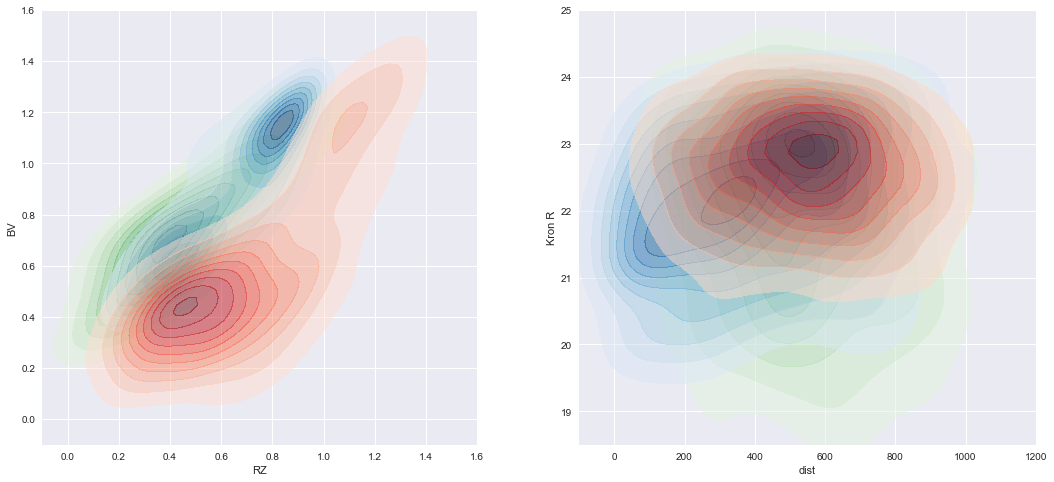

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
print colors
# getting rid of galaxies with anomalous colors
df_sel=df.loc[df['Kron R']<30]
for i in range(colors.size):
    df_sel=df_sel.query("(("+colors[i]+")>-10) & (("+colors[i]+")<10)")
    
# Label the data
foreground = df_sel.query("(z <= 0.4)")
cluster = df_sel.query("(z > 0.439-0.05) & (z<=0.439+0.05)")
background = df_sel.query("(z > 0.5)")

f, ax = plt.subplots(1,2,figsize=(18, 8))
ax[0].set_aspect("equal")
#ax[1].set_aspect("equal")

# Draw density plots
sns.kdeplot(foreground['RZ'], foreground['BV'],
            cmap="Greens", shade=True, shade_lowest=False,alpha=0.5,ax=ax[0])
sns.kdeplot(cluster['RZ'], cluster['BV'],
            cmap="Blues", shade=True, shade_lowest=False,alpha=0.5,ax=ax[0])
sns.kdeplot(background['RZ'], background['BV'],
            cmap="Reds", shade=True, shade_lowest=False,alpha=0.5,ax=ax[0])
ax[0].set_xlim([-0.1,1.6])
ax[0].set_ylim([-0.1,1.6])


sns.kdeplot(foreground['dist'], foreground['Kron R'],
            cmap="Greens", shade=True, shade_lowest=False,alpha=0.5,ax=ax[1])
sns.kdeplot(cluster['dist'], cluster['Kron R'],
            cmap="Blues", shade=True, shade_lowest=False,alpha=0.5,ax=ax[1])
sns.kdeplot(background['dist'], background['Kron R'],
            cmap="Reds", shade=True, shade_lowest=False,alpha=0.5,ax=ax[1])
ax[1].set_xlim([-100,1200])
ax[1].set_ylim([18.5,25])

While the separation between foreground and cluster members may be difficult, we may be able to separate these galaxies from the background sources. 

As said, the sample of background galaxies approximately equals the number of foreground and cluster galaxies.

In [10]:
print background.index.size
print foreground.index.size
print cluster.index.size

1263
633
756


## Training, testing, feature scaling

I have used the data described above to train and validate few classifiers. Their performance is quantified in terms of accuracy and recall. I experimented with neural network models constructed with ```Keras``` as well as with other classifiers built with ```sklearn```.

To begin, we split the sample into  training and  test sets. The test set amounts to 20% of the total sample. Because the features have significantly different numerical values, we scale and normalize them using the method ```scale``` from the ```sklearn.prepocessing``` module, which standardize the dataset (subtract the mean and divide by the std deviation).

In [12]:
# create feature array
X=np.zeros((df_sel.index.size,colors.size+2))
for i in range(colors.size):
    X[:,i]=df_sel[colors[i]]

X[:,colors.size]=df_sel['dist']
X[:,colors.size+1]=df_sel['Kron R']

# standardize the dataset
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)

from sklearn.feature_selection import SelectFromModel


# Here is the real labeling: 2 classes (unlensed: z<0.5) and lensed (z>0.5)

df_sel['label'] = np.where(df_sel['z'] < 0.5, 0, 1)
Y=df_sel['label'].values

# Split the sample into training and test sets. Train with 80% of the entries
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

### Building a Sequential model withe Keras

To begin we use ```keras``` to build a neural network to classify the galaxies into background and foreground/cluster galaxies. The model is trained and validated with the sets defined above. We use the ```adam``` algorithm to optimize the learning rate and the categorical cross-entropy as loss function. The optimization is controlled by an early-stopping monitor.

The neural-network architecture consists of an input layer with 100 units, three hidden layers again with 100 units and an output layer with two units. The activation function of each node in the input and in hidden layers is the Rectified Linear Activation Function (relu) and the activation function for the output layer is the Softmax.

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

y_train = keras.utils.to_categorical(Y_train, num_classes=2)
y_test = keras.utils.to_categorical(Y_test, num_classes=2)
y_all=keras.utils.to_categorical(Y, num_classes=2)

# Build a sequential model (linear stack of layers):
model=Sequential()

# Add layers: input layer (100 units), 3 hidden layers (100 units), 1 output layer (2 units). 
model.add(Dense(100,activation='relu',input_shape=(X_train.shape[1],)))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(2,activation='softmax'))
# compile and optimize the learning rate in the back-propagation process. Use the accuracy as metric
# for the optimization. Use the adam algorithm as optimizer and categorical cross-entropy as loss function.
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

# Fit and optimize the model. Use validation splits (20% of the data) to validate the model. Train until validation score improves.
# When it doesn't improve for two epochs, early-stops!
model_train=model.fit(X_train,y_train,epochs=30,validation_split=0.2,callbacks=[early_stopping_monitor])

# Make predictions with the test set:
pred=model.predict_classes(X_test)

print ''
from sklearn.metrics import classification_report
target_names = ['Foreground', 'Background']
#target_names = ['Cluster members', 'Background/Foreground']
print(classification_report(Y_test, pred, target_names=target_names))

Train on 1700 samples, validate on 425 samples
Epoch 1/30
1700/1700 [==============================] - 0s - loss: 0.4106 - acc: 0.8518 - val_loss: 0.2759 - val_acc: 0.9106
Epoch 2/30
1700/1700 [==============================] - 0s - loss: 0.2804 - acc: 0.9059 - val_loss: 0.2218 - val_acc: 0.9365
Epoch 3/30
1700/1700 [==============================] - 0s - loss: 0.2409 - acc: 0.9224 - val_loss: 0.2028 - val_acc: 0.9365
Epoch 4/30
1700/1700 [==============================] - 0s - loss: 0.2197 - acc: 0.9288 - val_loss: 0.1987 - val_acc: 0.9341
Epoch 5/30
1700/1700 [==============================] - 0s - loss: 0.2143 - acc: 0.9247 - val_loss: 0.1923 - val_acc: 0.9412
Epoch 6/30
1700/1700 [==============================] - 0s - loss: 0.2010 - acc: 0.9376 - val_loss: 0.1947 - val_acc: 0.9318
Epoch 7/30
1700/1700 [==============================] - 0s - loss: 0.1993 - acc: 0.9347 - val_loss: 0.1897 - val_acc: 0.9412
Epoch 8/30
1700/1700 [==============================] - 0s - loss: 0.1889 - ac

The classifier seems to perform very well, reaching precision and recall of order $\sim 94\%$.

Other architectures with different numbers of layers and nodes can been considered and evaluated on the validation set. The model capacity is been tweeked using the validation loss as reference metric.

Train on 1700 samples, validate on 425 samples
Epoch 1/30
1700/1700 [==============================] - 0s - loss: 0.5277 - acc: 0.7971 - val_loss: 0.3749 - val_acc: 0.8847
Epoch 2/30
1700/1700 [==============================] - 0s - loss: 0.3301 - acc: 0.8882 - val_loss: 0.2901 - val_acc: 0.8988
Epoch 3/30
1700/1700 [==============================] - 0s - loss: 0.2809 - acc: 0.9094 - val_loss: 0.2562 - val_acc: 0.9200
Epoch 4/30
1700/1700 [==============================] - 0s - loss: 0.2590 - acc: 0.9153 - val_loss: 0.2369 - val_acc: 0.9294
Epoch 5/30
1700/1700 [==============================] - 0s - loss: 0.2376 - acc: 0.9247 - val_loss: 0.2176 - val_acc: 0.9341
Epoch 6/30
1700/1700 [==============================] - 0s - loss: 0.2204 - acc: 0.9271 - val_loss: 0.2083 - val_acc: 0.9388
Epoch 7/30
1700/1700 [==============================] - 0s - loss: 0.2121 - acc: 0.9288 - val_loss: 0.2066 - val_acc: 0.9365
Epoch 8/30
1700/1700 [==============================] - 0s - loss: 0.2123 - ac

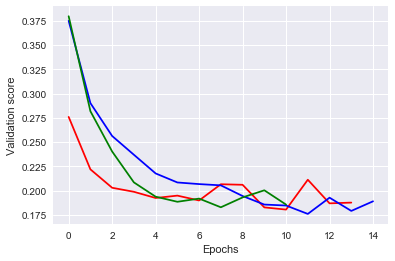

In [23]:
# Two alternative models: testing different numbers of units and of layers

model_alt=Sequential()
model_alt.add(Dense(50,activation='relu',input_shape=(X_train.shape[1],)))
model_alt.add(Dense(50,activation='relu'))
model_alt.add(Dense(50,activation='relu'))
model_alt.add(Dense(2,activation='softmax'))
model_alt.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model_alt1=Sequential()
model_alt1.add(Dense(50,activation='relu',input_shape=(X_train.shape[1],)))
model_alt1.add(Dense(50,activation='relu'))
model_alt1.add(Dense(50,activation='relu'))
model_alt1.add(Dense(50,activation='relu'))
model_alt1.add(Dense(2,activation='softmax'))
model_alt1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

# Fit the model
model_train_alt=model_alt.fit(X_train,y_train,epochs=30,validation_split=0.2,
                                callbacks=[early_stopping_monitor])

model_train_alt1=model_alt1.fit(X_train,y_train,epochs=30,validation_split=0.2,
                                callbacks=[early_stopping_monitor])

# Plot the validation loss
plt.plot(model_train.history['val_loss'], 'r',model_train_alt.history['val_loss'], 'b',
         model_train_alt1.history['val_loss'], 'g')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

The original model 


## Other classifiers

Using ```sklearn```, it is easy to implement other classifiers to compare to the multi-layer perceptron discussed above.

### Naive bayes
The first classifier we test here is the Gaussian Naive Bayes classifier. It uses the Bayes rule to compute the probability that one object belongs to a class assuming that the likelihood of the features is  Gaussian. The algorithm is used in many applications of text classification, but, in principle it should work here too.

In [24]:
from sklearn.naive_bayes import GaussianNB
clf_nb=GaussianNB()
clf_nb.fit(X_train,Y_train)

pred=clf_nb.predict(X_test)

from sklearn.metrics import accuracy_score

acc=accuracy_score(pred,Y_test)
print acc

0.842105263158


In [25]:
from sklearn.metrics import classification_report
#target_names = ['Foreground', 'Background']
target_names = ['Cluster members', 'Background/Foreground']
print(classification_report(Y_test, pred, target_names=target_names))

                       precision    recall  f1-score   support

      Cluster members       0.90      0.80      0.85       292
Background/Foreground       0.79      0.89      0.84       240

          avg / total       0.85      0.84      0.84       532



This classifier has a worse performance compared to the MLP. Precision and recall are $\sim 85\%$. The major limitation of this algorithm is given by the assumption of gaussianity of the features, which might not be good.

### Support Vector Machine

Another very popular algorithm for classification is the Support Vector Machine algorithm. In support vector machine we try to define the boundaries between classes by maximizing the distance of the data from the boundary themselves (margins). The algorithm can be used also in cases where the classes are not linearly separable. This is done by creating new features that are non-linear transformations of the features themselves. More generally  this operation can be done using the so-called "kernel trick". A kernel function is used to map the existing features into a larger feature space. There are several kind of kernels that one could use, including RBF, sigmoid, polynomial, etc. 

There are two parameters that define how the algorithm works. The first is called the "C" parameter. This parameter controls the trade-off between smooth decision boundaries and classifying training points correctly. The second is the "$\gamma$" parameter, which defines how far the influence of a single training example reaches.

In this analysis, we use a RBF kernel. We select the best parameters $C$ and $\gamma$ by performing a grid search with cross validation.

In [26]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
g=np.logspace(-3,3,12)
c=np.logspace(-3,3,12)
parameters = {'gamma':g,'C':c}
svr = svm.SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, Y_train)

print clf.best_score_
print  clf.best_estimator_.C
print  clf.best_estimator_.gamma

from sklearn import svm
# build a support vector classifier
clf_svc = svm.SVC(C=clf.best_estimator_.C,gamma=clf.best_estimator_.gamma,kernel='rbf') # gamma=1.0/2.0/sigma^2 
clf_svc.fit(X_train,Y_train)
pred=clf_svc.predict(X_test)

from sklearn.metrics import accuracy_score

acc=accuracy_score(pred,Y_test)
print acc

0.932705882353
1.87381742286
0.0432876128108
0.93045112782


We can create a classification report:

In [27]:
from sklearn.metrics import classification_report
target_names = ['Foreground', 'Background']
#target_names = ['Cluster members', 'Background/Foreground']
print(classification_report(Y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

 Foreground       0.94      0.93      0.94       292
 Background       0.91      0.93      0.92       240

avg / total       0.93      0.93      0.93       532



This shows that the performance of the SVM classifier is nearly identical to that of the MLP.

### Random forest classifier

Finally, we build and test a Random Forest Classifier. This classifier combines several decision trees to perform classification. Each tree is constructed from a bootstrapped sample of the training set. The predictive accuracy is improved by averaging the decisions. This also controls over-fitting. The classifier depends on several parameters. In this test we consider just the number of estimators (e.g. of decision trees), which will be combined. Again, we optimize the model by means of gridsearch with cross-validation.

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
n=np.arange(1,100,1,dtype=int)

parameters = {'n_estimators':n}
clf_=RandomForestClassifier()
clf = GridSearchCV(clf_, parameters)
clf.fit(X_train, Y_train)

print clf.best_score_
print  clf.best_estimator_.n_estimators

clf_rfc=RandomForestClassifier(n_estimators=clf.best_estimator_.n_estimators)
clf_rfc.fit(X_train,Y_train)
pred=clf_rfc.predict(X_test)
acc=accuracy_score(pred,Y_test)
print acc

0.932705882353
60
0.936090225564


In [14]:
print(classification_report(Y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

 Foreground       0.94      0.93      0.94       292
 Background       0.92      0.93      0.93       240

avg / total       0.93      0.93      0.93       532



# Testing the feature importance

This last part of the work is an attempt to identify the most informative features among those available. To do that we use the Recursive Feature Elimitation method with the random forest classifier.

In [15]:
my_features=[colors[0:colors.size],'dist','mag']
from sklearn.feature_selection import RFE


for n_feat in range(2,X.shape[1]):
    rfe = RFE(clf_rfc, n_feat)
    rfe = rfe.fit(X_train, Y_train)
    print(rfe.support_)
    print(rfe.ranking_)
    pred=rfe.predict(X_test)
    acc=accuracy_score(pred,Y_test)
    print acc
print my_features

[ True False False False False  True False False False False False False]
[ 1  4  9  7  3  1  5  2  6  8 11 10]
0.890977443609
[ True False False False False  True False  True False False False False]
[ 1  2  5  8  3  1  6  1  4  7 10  9]
0.915413533835
[ True  True False False False  True False  True False False False False]
[1 1 3 7 2 1 5 1 4 6 9 8]
0.919172932331
[ True  True False False False  True  True False  True False False False]
[1 1 3 6 2 1 1 4 1 5 8 7]
0.928571428571
[ True  True False False  True  True False  True  True False False False]
[1 1 4 5 1 1 3 1 1 2 7 6]
0.934210526316
[ True  True  True False  True  True False  True  True False False False]
[1 1 1 3 1 1 2 1 1 5 6 4]
0.928571428571
[ True  True False False  True  True  True  True  True  True False False]
[1 1 3 2 1 1 1 1 1 1 5 4]
0.934210526316
[ True  True  True False  True  True  True  True  True  True False False]
[1 1 1 2 1 1 1 1 1 1 4 3]
0.928571428571
[ True  True  True  True  True  True  True  True  True  

It looks like that most of the information is contained in the colors, rather than into the distance or the observed luminosity. The reason is that 

* the distance may be useful to separate the cluster members from the foreground and the background galaxies. However, when the foreground and the cluster galaxies are mixed together, the feature becomes uninformative;
* the observed brightness is also not very helpful to separate the foreground and the background galaxies because both classes contain many faint galaxies.

# Next steps

We may seek further improvements by either adding the size of the galaxies as a further constraint or the entire image of the each galaxy. In fact, morphological informations such as size, star forming regions, structure of the spiral arms etc. may contain information to separate the background from the foreground galaxies.

It may be possible that separating the cluster members from the background and foreground galaxies  results in an easier separation successive separation of background and foreground objects. 